# Best Buy Review Scraper and Analyzer

This notebook provides comprehensive functionality for:
- Scraping customer reviews from Best Buy products
- Cleaning and preprocessing review data
- Analyzing sentiment and extracting insights
- Generating visualizations and reports

**Author:** Thrisheiyan U K
**Date:** 2025  
**Version:** 2.0

## Configuration and Settings

In [6]:
# Configuration
import warnings
warnings.filterwarnings('ignore')

# Constants
CHROMEDRIVER_PATH = r"E:\Microsoft VS Code\Chromedriver\chromedriver-win64\chromedriver.exe"
MAX_REVIEWS = 1000
MAX_WORKERS = 20
RETRY_ATTEMPTS = 3
REQUEST_TIMEOUT = 30

## Library Imports

Importing all necessary libraries organized by category.

In [7]:
# === STANDARD LIBRARY ===
import os
import re
import time
import json
import logging
from pathlib import Path
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from urllib.parse import urlparse
from difflib import SequenceMatcher

# === DATA HANDLING & ANALYSIS ===
import pandas as pd
import numpy as np
from scipy import stats

# === VISUALIZATION ===
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# === MACHINE LEARNING ===
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

# === WEB SCRAPING ===
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import (
    NoSuchElementException, TimeoutException, WebDriverException
)

# === OFFICE DOCUMENT HANDLING ===
from openpyxl import load_workbook
from openpyxl.drawing.image import Image as XLImage
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN
from pptx.dml.color import RGBColor
from pptx.enum.shapes import MSO_SHAPE

# === PROGRESS & UTILITIES ===
from tqdm import tqdm

# === AI/ML APIs (Optional) ===
try:
    from ollama import Client
    OLLAMA_AVAILABLE = True
except ImportError:
    OLLAMA_AVAILABLE = False
    print("Ollama client not available. Some AI features will be disabled.")

# === LOGGING SETUP ===
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

print("✅ All libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔬 NumPy version: {np.__version__}")
print(f"📈 Matplotlib version: {plt.matplotlib.__version__}")

✅ All libraries imported successfully!
📊 Pandas version: 2.3.0
🔬 NumPy version: 2.2.6
📈 Matplotlib version: 3.10.3


In [8]:


def ensure_folder(folder_name):
    """Create folder if it doesn't exist."""
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

# Get current working directory
cwd = os.getcwd()

# Create base output folder
base_folder = os.path.join(cwd, 'review_output')
ensure_folder(base_folder)

# Create subfolders inside base folder
csv_folder = os.path.join(base_folder, 'review_csv')
excel_folder = os.path.join(base_folder, 'review_excel')
ppt_folder = os.path.join(base_folder, 'review_ppt')

for folder in [csv_folder, excel_folder, ppt_folder]:
    ensure_folder(folder)

print(f"Created folders:\n- {csv_folder}\n- {excel_folder}\n- {ppt_folder}")


Created folders:
- e:\Intern\review_output\review_csv
- e:\Intern\review_output\review_excel
- e:\Intern\review_output\review_ppt


In [9]:

import time
from datetime import datetime, timedelta


def convert_relative_date_to_absolute(date_str, current_date=datetime(2025, 5, 26)):
    date_str = date_str.lower().strip()
    if date_str == 'today':
        return current_date.strftime('%Y-%m-%d')
    if date_str == 'yesterday':
        return (current_date - timedelta(days=1)).strftime('%Y-%m-%d')
    match = re.match(r'(\d+)\s+(second|minute|hour|day|week|month|year)s?\s+ago', date_str)
    if not match:
        return date_str
    value, unit = int(match.group(1)), match.group(2)
    if unit in ['second', 'minute', 'hour']:
        return current_date.strftime('%Y-%m-%d')
    elif unit == 'day':
        delta = timedelta(days=value)
    elif unit == 'week':
        delta = timedelta(weeks=value)
    elif unit == 'month':
        delta = timedelta(days=30 * value)
    elif unit == 'year':
        delta = timedelta(days=365 * value)
    else:
        return date_str
    absolute_date = current_date - delta
    return absolute_date.strftime('%Y-%m-%d')

def get_driver(chromedriver_path, headless=True):
    chrome_options = Options()
    if headless:
        chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--window-size=1920,1080")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument("--incognito")
    chrome_options.add_argument("--log-level=3")
    chrome_options.add_experimental_option('excludeSwitches', ['enable-logging'])
    prefs = {"profile.managed_default_content_settings.images": 2}
    chrome_options.add_experimental_option("prefs", prefs)
    chrome_options.page_load_strategy = "eager"
    service = Service(chromedriver_path)
    return webdriver.Chrome(service=service, options=chrome_options)

def extract_product_name(driver):
    # Try common selectors for Best Buy product name/description
    selectors = [
        (By.CSS_SELECTOR, ".sku-title h1"),
        (By.CSS_SELECTOR, 'a[data-track="Product Description"]'),
        (By.CSS_SELECTOR, 'h1[data-track="Product Title"]'),
        (By.CSS_SELECTOR, 'h2.product-title a'),
        (By.CSS_SELECTOR, 'h2.heading-6.product-title.mb-100 a')
    ]
    for by, selector in selectors:
        try:
            elem = driver.find_element(by, selector)
            name = elem.text.strip()
            if name:
                return name
        except Exception:
            continue
    return "Unknown_Product"

def extract_reviews_from_page(driver):
    reviews = []
    review_elements = driver.find_elements(By.CSS_SELECTOR, 'li.review-item')
    for review in review_elements:
        try:
            title = review.find_element(By.CSS_SELECTOR, '.review-title').text
        except:
            title = ""
        try:
            content = review.find_element(By.CSS_SELECTOR, '.pre-white-space').text
        except:
            content = ""
        try:
            try:
                rating = review.find_element(By.CSS_SELECTOR, '.c-review-average').text
            except:
                rating = review.find_element(By.CSS_SELECTOR, '.review-rating').text
        except:
            rating = ""
        try:
            try:
                date_raw = review.find_element(By.CSS_SELECTOR, '.review-date').text
            except:
                date_raw = review.find_element(By.CSS_SELECTOR, '.submission-date').text
            date = convert_relative_date_to_absolute(date_raw)
        except:
            date = ""
        try:
            try:
                reviewer = review.find_element(By.CSS_SELECTOR, '.user-display-name').text
            except:
                reviewer = review.find_element(By.CSS_SELECTOR, '.ugc-author.v-fw-medium.body-copy-lg').text
        except:
            reviewer = ""
        reviews.append({
            'title': title,
            'content': content,
            'rating': rating,
            'date': date,
            'reviewer': reviewer
        })
    return reviews

def extract_review_counts(driver):
    try:
        pagination = driver.find_element(By.CSS_SELECTOR, 'div.reviews-pagination')
        pagination_text = pagination.text
        match = re.search(r'Showing\s+(\d+)-(\d+)\s+of\s+([\d,]+)', pagination_text)
        if match:
            current_min = int(match.group(1))
            current_max = int(match.group(2))
            total = int(match.group(3).replace(',', ''))
            return current_min, current_max, total
        else:
            return None, None, None
    except Exception:
        return None, None, None

def scrape_page_reviews(product_url, chromedriver_path, page_num, headless=True):
    driver = get_driver(chromedriver_path, headless=headless)
    url = f"{product_url}?page={page_num}&sort=LOWEST_RATING"
    start_time = time.time()
    driver.get(url)
    wait = WebDriverWait(driver, 10)
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, 'li.review-item')))
    reviews = extract_reviews_from_page(driver)
    driver.quit()
    elapsed = time.time() - start_time
    return reviews, elapsed

def scrape_bestbuy_reviews_parallel(product_url, chromedriver_path, max_reviews=None, headless=True, max_workers=6):
    driver = get_driver(chromedriver_path, headless=headless)
    driver.get(product_url)
    wait = WebDriverWait(driver, 10)
    try:
        sort_dropdown = wait.until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "select.tb-select"))
        )
        select = Select(sort_dropdown)
        select.select_by_value("MOST_HELPFUL")
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "li.review-item")))
    except Exception:
        pass
    current_min, current_max, total_reviews = extract_review_counts(driver)
    driver.quit()

    if total_reviews is None:
        total_reviews = max_reviews if max_reviews else 1000

    reviews_per_page = current_max - current_min + 1 if current_min and current_max else 20
    total_pages = (total_reviews // reviews_per_page) + 1

    if max_reviews:
        max_pages = (max_reviews // reviews_per_page) + 1
        total_pages = min(total_pages, max_pages)

    all_reviews = []
    page_times = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for page_num in range(1, total_pages + 1):
            futures.append(executor.submit(scrape_page_reviews, product_url, chromedriver_path, page_num, headless))
        with tqdm(total=max_reviews if max_reviews else total_reviews, desc="Reviews scraped", unit="review") as review_bar:
            for future in as_completed(futures):
                page_reviews, elapsed = future.result()
                page_times.append(elapsed)
                for review in page_reviews:
                    if max_reviews and len(all_reviews) >= max_reviews:
                        break
                    all_reviews.append(review)
                    review_bar.update(1)
                if max_reviews and len(all_reviews) >= max_reviews:
                    break
    avg_time = sum(page_times) / len(page_times) if page_times else 0
    print(f"Average time per page: {avg_time:.2f} seconds")
    return all_reviews[:max_reviews] if max_reviews is not None else all_reviews

def write_csv(dataframe, file_name):
    base, ext = os.path.splitext(file_name)
    counter = 1
    new_filename = file_name
    while os.path.exists(new_filename):
        new_filename = f"{base}_{counter}{ext}"
        counter += 1
    dataframe.to_csv(new_filename, index=False)
    print(f"Saved to {new_filename}")

def convert_product_url_to_review_url(product_url):
    parsed = urlparse(product_url)
    path_parts = parsed.path.strip('/').split('/')

    # If already a review URL, return as is
    if 'reviews' in path_parts:
        return product_url

    # If it's a /product/ URL or /site/ URL
    # Find the SKU (last part)
    sku = path_parts[-1]
    # Try to extract the product slug (all parts between 'product' and the SKU)
    if 'product' in path_parts:
        idx = path_parts.index('product')
        product_slug_parts = path_parts[idx+1:-1]
        product_slug = '-'.join(product_slug_parts) if product_slug_parts else ''
    elif 'site' in path_parts:
        # /site/slug/sku
        product_slug_parts = path_parts[1:-1]
        product_slug = '-'.join(product_slug_parts) if product_slug_parts else ''
    else:
        product_slug = ''
    scheme = parsed.scheme
    netloc = parsed.netloc
    if product_slug:
        review_url = f"{scheme}://{netloc}/site/reviews/{product_slug}/{sku}"
    else:
        review_url = f"{scheme}://{netloc}/site/reviews/{sku}"
    return review_url

if __name__ == "__main__":
    CHROMEDRIVER_PATH = r"E:\Microsoft VS Code\Chromedriver\chromedriver-win64\chromedriver.exe"
    INPUT_URL = input("Enter any Best Buy product or review URL: ").strip()
    PRODUCT_URL = convert_product_url_to_review_url(INPUT_URL)

    MAX_REVIEWS = 1000
    MAX_WORKERS = 20

    # Extract product name/description (using robust selectors)
    driver = get_driver(CHROMEDRIVER_PATH)
    driver.get(PRODUCT_URL)
    product_name = extract_product_name(driver)
    driver.quit()
    print(f"Product description: {product_name}")

    # Prepare output directory (no product-specific folder)
    output_dir = os.path.join(os.getcwd(), 'review_output', 'review_csv')
    os.makedirs(output_dir, exist_ok=True)

    # Scrape reviews
    start = time.time()
    reviews = scrape_bestbuy_reviews_parallel(PRODUCT_URL, CHROMEDRIVER_PATH, max_reviews=MAX_REVIEWS, max_workers=MAX_WORKERS)
    print(f"Scraped {len(reviews)} reviews in {time.time()-start:.2f} seconds.")

    # Save reviews to CSV (no product name column)
    df = pd.DataFrame(reviews)
    output_path = os.path.join(output_dir, 'bestbuy_reviews.csv')
    write_csv(df, output_path)



Product description: LG - 24" Front Control Built-In Stainless Steel Tub Dishwasher with 3rd Rack, Quadwash, and 48dba - PrintProof Stainless steel


Reviews scraped: 100%|██████████| 1000/1000 [02:59<00:00,  5.58review/s]


Average time per page: 58.22 seconds
Scraped 1000 reviews in 214.68 seconds.
Saved to e:\Intern\review_output\review_csv\bestbuy_reviews_1.csv


In [10]:
print(product_name)

LG - 24" Front Control Built-In Stainless Steel Tub Dishwasher with 3rd Rack, Quadwash, and 48dba - PrintProof Stainless steel


In [11]:
csv_path = os.path.join(os.getcwd(), 'review_output', 'review_csv', 'bestbuy_reviews.csv')
df = pd.read_csv(csv_path)
df.head()


,title,content,rating,date,reviewer
0,AE error,Loved the washer and features and would have g...,Rated 1 out of 5 stars,2025-02-25,CristianM
1,DO NOT buy this machine,This is the worst dishwasher I have ever owned...,Rated 1 out of 5 stars,2025-01-26,LoraK
2,I wouldn't recommend.,Don't buy. This machine is good until it stop...,Rated 1 out of 5 stars,2025-01-26,MarieB
3,"Do not buy, has known issues! Should be recalled.","DO NOT BUY THIS DISHWASHER, it is FAULTY! Work...",Rated 1 out of 5 stars,2025-01-26,VPReyes
4,Front panel very fragile,"The front panel started cracking, placed servi...",Rated 1 out of 5 stars,2025-01-26,Megalodon


In [12]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    # Remove extra spaces, newlines, tabs
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove HTML tags (if present)
    text = re.sub(r'<[^>]*>', '', text)
    # Remove special characters (adjust as needed)
    text = re.sub(r'[^\w\s]', '', text, flags=re.UNICODE)
    return text

def convert_relative_date_to_absolute(date_str, current_date=datetime.today()):
    if not isinstance(date_str, str):
        return date_str
    date_str = date_str.lower().strip()
    if date_str == 'today':
        return current_date.strftime('%Y-%m-%d')
    if date_str == 'yesterday':
        return (current_date - timedelta(days=1)).strftime('%Y-%m-%d')
    match = re.match(r'(\d+)\s+(second|minute|hour|day|week|month|year)s?\s+ago', date_str)
    if not match:
        return date_str
    value, unit = int(match.group(1)), match.group(2)
    if unit in ['second', 'minute', 'hour']:
        return current_date.strftime('%Y-%m-%d')
    elif unit == 'day':
        delta = timedelta(days=value)
    elif unit == 'week':
        delta = timedelta(weeks=value)
    elif unit == 'month':
        delta = timedelta(days=30 * value)
    elif unit == 'year':
        delta = timedelta(days=365 * value)
    else:
        return date_str
    absolute_date = current_date - delta
    return absolute_date.strftime('%Y-%m-%d')


In [13]:

df = df.drop_duplicates(subset=['title', 'content', 'reviewer', 'date'], keep='first')

df['title'] = df['title'].apply(clean_text)
df['content'] = df['content'].apply(clean_text)
df['rating'] = df['rating'].apply(clean_text)
df['reviewer'] = df['reviewer'].apply(clean_text)

df['date'] = df['date'].apply(convert_relative_date_to_absolute)

df = df[df['content'].str.strip().astype(bool)]


In [14]:

if pd.api.types.is_numeric_dtype(df['rating']):
    df_neg = df[(df['rating'] >= 1) & (df['rating'] <= 4)]
else:
    df['rating_num'] = df['rating'].str.extract(r'(\d+)')[0].astype(float)
    df_neg = df[(df['rating_num'] >= 1) & (df['rating_num'] <= 4)]
    df_neg = df_neg.drop(columns=['rating_num'])


In [15]:

# Lowercase, remove punctuation, stopwords, etc. (for NLP)
def preprocess_for_nlp(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    return text

df_neg['content_clean'] = df_neg['content'].apply(preprocess_for_nlp)


In [16]:
print(df.isnull().sum())

title         0
content       0
rating        0
date          0
reviewer      0
rating_num    0
dtype: int64


In [17]:
def write_csv(dataframe, file_name):
    # Remove 5-star reviews
    filtered_df = dataframe[dataframe['rating'] != 'Rated 5 out of 5 stars']
    base, ext = os.path.splitext(file_name)
    counter = 1
    new_filename = file_name
    while os.path.exists(new_filename):
        new_filename = f"{base}_{counter}{ext}"
        counter += 1
    filtered_df.to_csv(new_filename, index=False)
    print(f"Saved to {new_filename}")

output_cleaned_path = os.path.join(os.getcwd(), 'review_output', 'review_csv', 'bestbuy_reviews_cleaned.csv')
write_csv(df, output_cleaned_path)


Saved to e:\Intern\review_output\review_csv\bestbuy_reviews_cleaned.csv


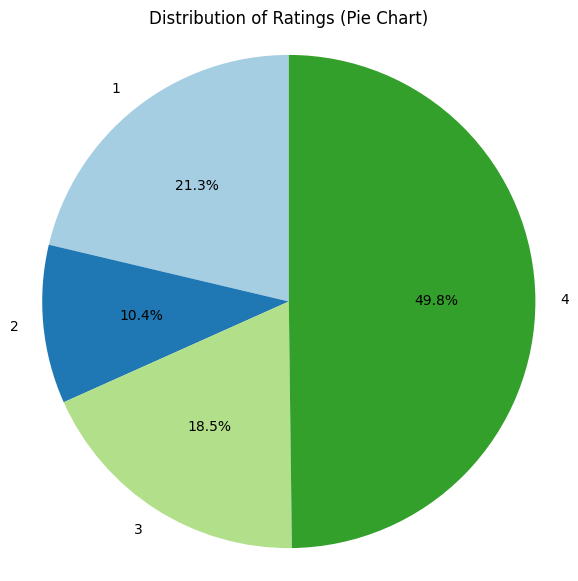

In [18]:


csv_path = os.path.join(os.getcwd(), 'review_output', 'review_csv', 'bestbuy_reviews_cleaned.csv')
df = pd.read_csv(csv_path)

df['rating_num'] = pd.to_numeric(df['rating_num'], errors='coerce')
df = df.dropna(subset=['rating_num'])
df.drop(columns=['rating'], inplace=True)

rating_counts = df['rating_num'].value_counts().sort_index()

plt.figure(figsize=(7,7))
plt.pie(rating_counts.values, labels=rating_counts.index.astype(int), autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribution of Ratings (Pie Chart)')
plt.axis('equal')
plt.show()


Filtering & Topic Generation (Mistral):   0%|          | 0/1000 [00:00<?, ?it/s]2025-07-20 10:50:06,755 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 10:50:07,445 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 10:50:07,854 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 10:50:08,426 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 10:50:08,711 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 10:50:09,455 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 10:50:10,005 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 10:50:11,218 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 10:50:11,683 - INFO - HTTP Request: POST http://127.0.0.1:114

Kept 832 problem-focused reviews out of 1000 total reviews.


Embedding (mxbai): 100%|██████████| 26/26 [00:27<00:00,  1.06s/it]


Embeddings saved to e:\Intern\review_output\embeddings.npy

Finding the optimal number of clusters using the Automated Elbow Method...


Calculating Inertia for k clusters: 100%|██████████| 19/19 [00:07<00:00,  2.51it/s]



Automatically detected optimal number of clusters: 8
Elbow method plot with detected knee saved as 'elbow_method_automated.png'

Running KMeans with optimal cluster count: 8

Naming the identified clusters...


Naming clusters: 100%|██████████| 8/8 [00:25<00:00,  3.23s/it]


Clustering complete!
Saved 832 reviews with 8 clusters to 'e:\Intern\review_output\review_csv\Improved_Clusters_Automated.csv'


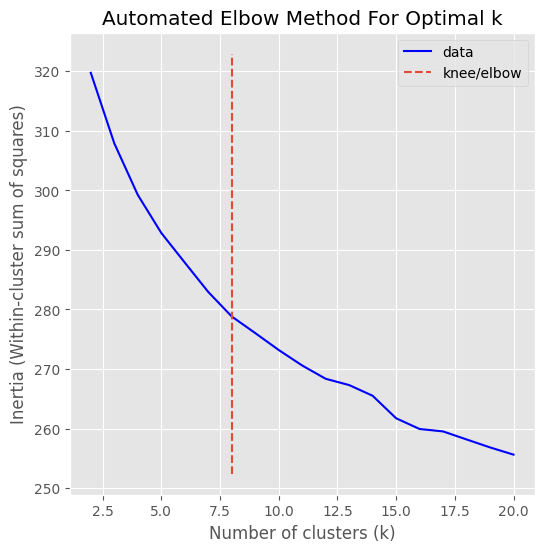

In [19]:
import concurrent.futures

try:
    csv_path = os.path.join(os.getcwd(), 'review_output', 'review_csv', 'bestbuy_reviews_cleaned.csv')
    df = pd.read_csv(csv_path)

except FileNotFoundError:
    print("Error: 'bestbuy_reviews_cleaned.csv' not found. Please ensure the path is correct.")
    try:
        print("Attempting to load 'Cluster.csv' as a fallback.")
        df = pd.read_csv('Cluster.csv')
    except FileNotFoundError:
        print("Error: Fallback 'Cluster.csv' also not found. Please upload the necessary file.")
        exit()


# Ensure all necessary columns exist, fill missing ones with empty string or NaN
for col in ['title', 'content', 'date', 'reviewer', 'rating']:
    if col not in df.columns:
        df[col] = np.nan

reviews = df['content'].fillna('').tolist()
client = Client()
# --- 2. Generate Review-wise Topics (Mistral) ---
if 'About' not in df.columns:
    def get_review_topic(text):
        prompt = (
            "Read this review. If it mentions a specific problem or issue, provide a concise problem-focused topic "
            "in a short phrase without any prefix like 'Main Topic' or parentheses. Example: 'Poor dish cleaning'. "
            "If the review is positive, irrelevant, or mentions no issues, output EXACTLY: 'NO_ISSUE'.\n\n"
            f"Review:\n{text}"
        )
        try:
            response = client.generate(model='mistral', prompt=prompt)
            topic = response['response'].strip().split('\n')[0]
            # Strict NO_ISSUE and short/empty filtering
            if not topic or topic.strip().upper() == 'NO_ISSUE' or len(topic.strip()) < 5:
                return None
            return re.sub(r"Main Topic\s*\(|\)|:", "", topic).strip()
        except Exception as e:
            print(f"Error generating topic: {e}")
            return None

    with concurrent.futures.ThreadPoolExecutor(max_workers=25) as executor:
        about_per_review = list(tqdm(executor.map(get_review_topic, reviews),
                                     total=len(reviews),
                                     desc="Filtering & Topic Generation (Mistral)"))
    df['About'] = about_per_review
else:
    print("Skipping topic generation as 'About' column already exists.")


# --- 3. Strict Filtering: Remove positive/irrelevant reviews ---
def is_problematic(about):
    if not isinstance(about, str):
        return False
    about_clean = about.strip().lower()
    # More robust check for 'no issue'
    if 'no_issue' in about_clean or 'no issue' in about_clean:
        return False
    if len(about_clean) < 5: # Filter out very short, likely unhelpful topics
        return False
    return True

problem_df = df[df['About'].apply(is_problematic)].copy()
problem_reviews = problem_df['content'].tolist()
print(f"Kept {len(problem_df)} problem-focused reviews out of {len(df)} total reviews.")


# --- 4. Generate Embeddings ---
embedding_path = os.path.join(os.getcwd(), 'review_output', 'embeddings.npy')
if os.path.exists(embedding_path):
    print("Loading existing embeddings...")
    embeddings = np.load(embedding_path)
    # Ensure the number of embeddings matches the number of problem reviews
    if len(embeddings) != len(problem_reviews):
        print("Embeddings file does not match review count. Regenerating...")
        regenerate_embeddings = True
    else:
        regenerate_embeddings = False
else:
    regenerate_embeddings = True

if regenerate_embeddings:
    embeddings = []
    batch_size = 32
    for i in tqdm(range(0, len(problem_reviews), batch_size), desc="Embedding (mxbai)"):
        batch = problem_reviews[i:i+batch_size]
        try:
            result = client.embed(model='mxbai-embed-large', input=batch)
            embeddings.extend(result['embeddings'])
        except Exception as e:
            print(f"Embedding error: {e}")
            embeddings.extend([np.zeros(1024)] * len(batch)) 
    embeddings = np.array(embeddings, dtype=np.float32)
    np.save(embedding_path, embeddings)
    print(f"Embeddings saved to {embedding_path}")


# --- 5. Find Optimal Number of Clusters (Automated Elbow Method) ---
print("\nFinding the optimal number of clusters using the Automated Elbow Method...")
inertia = []
K = range(2, 21)
for k in tqdm(K, desc="Calculating Inertia for k clusters"):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings)
    inertia.append(kmeans.inertia_)

kl = KneeLocator(K, inertia, curve='convex', direction='decreasing')
optimal_n_clusters = kl.elbow

if optimal_n_clusters is None:
    print("Could not automatically find the elbow point. Defaulting to 8 clusters.")
    optimal_n_clusters = 8
else:
    print(f"\nAutomatically detected optimal number of clusters: {optimal_n_clusters}")
    # Plotting the Elbow Method graph with the detected knee
    plt.style.use("ggplot")
    kl.plot_knee()
    elbow_plot_path = 'elbow_method_automated.png'
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (Within-cluster sum of squares)")
    plt.title("Automated Elbow Method For Optimal k")
    plt.savefig(elbow_plot_path)
    print(f"Elbow method plot with detected knee saved as '{elbow_plot_path}'")


# --- 6. KMeans Clustering with Optimal n_clusters ---
print(f"\nRunning KMeans with optimal cluster count: {optimal_n_clusters}")
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings)
problem_df['cluster_id'] = cluster_labels


# --- 7. Name Clusters ---
def name_cluster(i):
    cluster_topics = problem_df[problem_df['cluster_id'] == i]['About'].tolist()
    # Provide more context to the LLM for better naming
    topics_sample = "\n- ".join(cluster_topics[:30])
    prompt = (
        "You are an expert at summarizing customer complaint topics for product reviews. "
        "Given the following list of specific problem topics, identify the single main underlying issue. "
        "Output ONLY a concise and descriptive heading for this main issue. "
        "For example, if topics are 'Doesn't dry dishes', 'Water left on plates', 'Still wet after cycle', the heading should be 'Poor Drying Performance'.\n\n"
        f"Problem Topics:\n- {topics_sample}"
    )
    try:
        response = client.generate(model='llama3', prompt=prompt)
        cluster_name = response['response'].strip()
        # Clean the name from any markdown or quotes
        cluster_name = re.sub(r'^\*+|\*+$', '', cluster_name) # Remove leading/trailing asterisks
        cluster_name = re.sub(r'^"+|"+$', '', cluster_name) # Remove leading/trailing quotes
        cluster_name = re.sub(r'^.*:\s*', '', cluster_name) # Remove prefixes like "Heading:"
        return cluster_name.strip()
    except Exception as e:
        print(f"Error naming cluster {i}: {e}")
        return f"Cluster_{i}" # Fallback name

print("\nNaming the identified clusters...")
cluster_names = {}
for i in tqdm(range(optimal_n_clusters), desc="Naming clusters"):
    cluster_names[i] = name_cluster(i)

problem_df['Cluster'] = problem_df['cluster_id'].map(cluster_names)


# --- 8. Save Results ---
def get_unique_filename(base_path, base_filename):
    full_path = os.path.join(base_path, base_filename)
    if not os.path.exists(full_path):
        return full_path
    name, ext = os.path.splitext(base_filename)
    i = 1
    while True:
        new_filename = f"{name}_{i}{ext}"
        new_full_path = os.path.join(base_path, new_filename)
        if not os.path.exists(new_full_path):
            return new_full_path
        i += 1 

# Define output file details
base_path = os.path.join(os.getcwd(), 'review_output', 'review_csv')
# Create directory if it doesn't exist
os.makedirs(base_path, exist_ok=True)
base_filename = 'Improved_Clusters_Automated.csv'
unique_filename = get_unique_filename(base_path, base_filename)

# Define final columns and save
final_columns = ['title', 'content', 'date', 'reviewer', 'rating', 'About', 'Cluster']
# Ensure 'rating' column exists from original df
if 'rating_num' in problem_df.columns:
    problem_df = problem_df.rename(columns={'rating_num': 'rating'})

# Save the final dataframe
problem_df[final_columns].to_csv(unique_filename, index=False)

print(f"\nClustering complete!")
print(f"Saved {len(problem_df)} reviews with {optimal_n_clusters} clusters to '{unique_filename}'")


In [20]:


base_dir = os.path.join(os.getcwd(), 'review_output', 'review_csv')
input_csv = os.path.join(base_dir, 'Improved_Clusters_Automated.csv')
output_csv = os.path.join(base_dir, 'Optimized_Clustered_Dataset.csv')

def extract_main_cluster(text):
    """
    Extracts only the main cluster label from a text string.
    - If double asterisks are present, returns the text inside.
    - If double asterisks are at the end of a phrase, returns the part before '**'.
    - If a numbered list with hyphen, returns the label after the hyphen.
    - Otherwise, returns the first line or phrase before explanation.
    """
    if pd.isna(text):
        return None
    s = str(text).strip()
    # If text is wrapped in double asterisks
    match = re.search(r'\*\*(.*?)\*\*', s)
    if match:
        return match.group(1).strip()
    # If text ends with double asterisks after cluster label
    match = re.match(r'^(.*?)\*\*', s)
    if match:
        return match.group(1).strip()
    # If it's a numbered list with hyphen (e.g., "1. ... - Cluster Label")
    match = re.match(r'^\s*\d+\.\s.*?-\s*(.+)', s)
    if match:
        return match.group(1).strip()
    # Otherwise, take the first line or phrase before explanation
    return s.split('\n')[0].strip()

def get_unique_clusters(df, col='Cluster'):
    """
    Returns a sorted list of unique cluster labels from the DataFrame.
    """
    return sorted(df[col].dropna().unique())

def build_merge_map(unique_clusters, similarity_threshold=0.85):
    """
    Builds a mapping of clusters to canonical labels using fuzzy matching.
    Returns a dictionary: {original_label: merged_label}
    """
    canonical_labels = []
    merge_map = {}
    for label in unique_clusters:
        found = False
        for canon in canonical_labels:
            ratio = SequenceMatcher(None, label.lower(), canon.lower()).ratio()
            if ratio >= similarity_threshold:
                merge_map[label] = canon
                found = True
                break
        if not found:
            canonical_labels.append(label)
            merge_map[label] = label
    return merge_map

if __name__ == "__main__":
    df = pd.read_csv(input_csv)
    # Extract main cluster labels
    df['Cluster'] = df['Cluster'].apply(extract_main_cluster)
    df['Cluster'] = df['Cluster'].fillna("Uncategorized")
    df.sort_values(by=['Cluster'], inplace=True)

    # Get unique clusters before merging
    unique_clusters = get_unique_clusters(df, col='Cluster')
    print("Unique clusters before merging:")
    for c in unique_clusters:
        print("-", c)

    # Build merge map using fuzzy matching
    merge_map = build_merge_map(unique_clusters, similarity_threshold=0.85)

    print("\nCluster merge mapping (auto-detected):")
    for orig, merged in merge_map.items():
        if orig != merged:
            print(f'"{orig}" → "{merged}"')

    # Apply merge map to cluster column
    df['Cluster'] = df['Cluster'].map(merge_map).fillna(df['Cluster'])

    # Save cleaned and merged dataset
    df.to_csv(output_csv, index=False)
    print(f"\nOptimized and merged clustered data saved to: {output_csv}")

    # Show unique clusters after merging
    merged_clusters = get_unique_clusters(df, col='Cluster')
    print("\nUnique clusters after merging:")
    for c in merged_clusters:
        print("-", c)


Unique clusters before merging:
- Insufficient Performance and Ease of Use
- Poor Design and Functionality
- Poor Drying Performance
- Poor Performance and Cleaning Efficiency
- Poor Product Quality and Reliability
- Reliability and Durability Issues

Cluster merge mapping (auto-detected):

Optimized and merged clustered data saved to: e:\Intern\review_output\review_csv\Optimized_Clustered_Dataset.csv

Unique clusters after merging:
- Insufficient Performance and Ease of Use
- Poor Design and Functionality
- Poor Drying Performance
- Poor Performance and Cleaning Efficiency
- Poor Product Quality and Reliability
- Reliability and Durability Issues


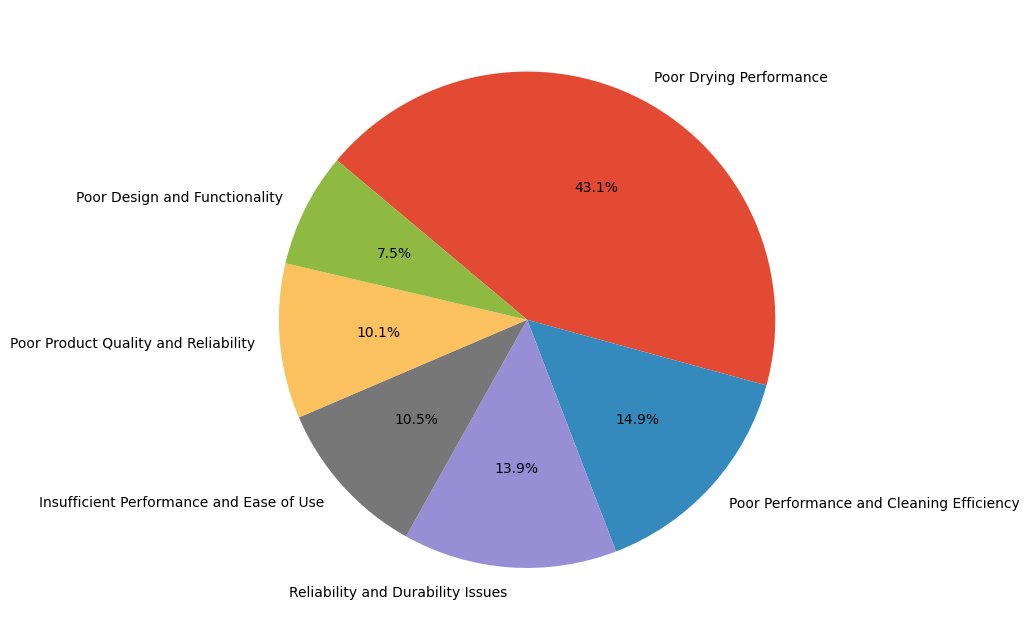

In [21]:
import matplotlib.pyplot as plt
csv_path = os.path.join(os.getcwd(), 'review_output', 'review_csv', 'Optimized_Clustered_Dataset.csv')
df = pd.read_csv(csv_path)


# Count the number of reviews in each cluster
cluster_counts = df['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']

# Plot the pie chart
plt.figure(figsize=(10, 10))
plt.pie(
    cluster_counts['Count'],
    labels=cluster_counts['Cluster'],
    autopct='%1.1f%%',
    startangle=140,
    counterclock=False
)
cluster_counts = df['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']

plt.tight_layout()
plt.show()



In [22]:


# --- Folder Setup ---
csv_path = os.path.join(os.getcwd(), 'review_output', 'review_csv', 'Optimized_Clustered_Dataset.csv')
image_dir = os.path.join(os.getcwd(), 'review_output', 'review_csv')
excel_dir = os.path.join(os.getcwd(), 'review_output', 'review_excel')
os.makedirs(excel_dir, exist_ok=True)

pareto_chart_path = os.path.join(image_dir, 'pareto_chart.png')
visual_chart_path = os.path.join(image_dir, 'cluster_visual.png')
excel_path = os.path.join(excel_dir, 'Clustered_Reviews_with_pareto.xlsx')

# --- 1. Load Data ---
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV file not found: {csv_path}")
df = pd.read_csv(csv_path)

# --- 2. Pareto Summary ---
cluster_counts = df['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
cluster_counts = cluster_counts.sort_values(by='Count', ascending=False).reset_index(drop=True)
cluster_counts['Cumulative_Count'] = cluster_counts['Count'].cumsum()
total = cluster_counts['Count'].sum()
cluster_counts['Cumulative_Percentage'] = 100 * cluster_counts['Cumulative_Count'] / total

# --- 3. Pareto Chart (Top 10) ---
top_10_issues = cluster_counts.head(10)
fig, ax1 = plt.subplots(figsize=(12, 6))
bars = ax1.bar(
    top_10_issues['Cluster'], top_10_issues['Count'],
    color='lightcoral', edgecolor='black', linewidth=1.5, hatch='//'
)
ax1.set_xlabel('Problem Cluster')
ax1.set_ylabel('Number of Reviews', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticklabels(top_10_issues['Cluster'], rotation=45, ha='right')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='darkred')

ax2 = ax1.twinx()
ax2.plot(top_10_issues['Cluster'], top_10_issues['Cumulative_Percentage'],
         color='darkorange', marker='o', linestyle='-')
ax2.set_ylabel('Cumulative Percentage (%)', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')
ax2.set_ylim(0, 110)
plt.title('Pareto Analysis: Top 10 Dishwasher Problem Clusters')
plt.tight_layout()
plt.savefig(pareto_chart_path)
plt.close(fig)

# --- 4. Visual Chart for All Clusters ---
fig2, ax = plt.subplots(figsize=(12, 6))
bars_all = ax.bar(
    cluster_counts['Cluster'], cluster_counts['Count'],
    color='mediumseagreen', edgecolor='black', linewidth=1.2, hatch='\\'
)
ax.set_xlabel('Problem Cluster')
ax.set_ylabel('Number of Reviews')
ax.set_xticklabels(cluster_counts['Cluster'], rotation=45, ha='right')
plt.title('All Dishwasher Problem Clusters')
for bar in bars_all:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{int(height)}',
            ha='center', va='bottom', fontsize=9, fontweight='bold', color='darkgreen')
plt.tight_layout()
plt.savefig(visual_chart_path)
plt.close(fig2)

# --- 5. Save Excel with Sheets and Images ---
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    df.to_excel(writer, sheet_name='original_data', index=False)
    cluster_counts.to_excel(writer, sheet_name='pareto', index=False)
    cluster_counts.to_excel(writer, sheet_name='visual', index=False)

wb = load_workbook(excel_path)
ws_pareto = wb['pareto']
ws_visual = wb['visual']

if os.path.exists(pareto_chart_path):
    img_pareto = XLImage(pareto_chart_path)
    ws_pareto.add_image(img_pareto, 'E2')

if os.path.exists(visual_chart_path):
    img_visual = XLImage(visual_chart_path)
    ws_visual.add_image(img_visual, 'E2')

wb.save(excel_path)
print(f"Pareto summary and charts saved to '{excel_path}' (see sheets 'pareto' and 'visual').")


Pareto summary and charts saved to 'e:\Intern\review_output\review_excel\Clustered_Reviews_with_pareto.xlsx' (see sheets 'pareto' and 'visual').


In [23]:
import os
import pandas as pd
from ollama import Client

excel_path = os.path.join(os.getcwd(), 'review_output', 'review_excel', 'Clustered_Reviews_with_pareto.xlsx')
df = pd.read_excel(excel_path, sheet_name='original_data')

# 1. Pareto summary
cluster_counts = df['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
cluster_counts = cluster_counts.sort_values(by='Count', ascending=False).reset_index(drop=True)
cluster_counts['Cumulative_Count'] = cluster_counts['Count'].cumsum()
total = cluster_counts['Count'].sum()
cluster_counts['Cumulative_Percentage'] = 100 * cluster_counts['Cumulative_Count'] / total

# 2. Get top 10 recurring issues
top_10 = cluster_counts.head(10)

# 3. For each cluster, find the top 2 most frequent "About" topics
top_problem_1, top_problem_2, problem_explanations = [], [], []
client = Client()

for idx, row in top_10.iterrows():
    cluster = row['Cluster']
    about_counts = df[df['Cluster'] == cluster]['About'].value_counts(dropna=True)
    prob1 = about_counts.index[0] if len(about_counts) > 0 else ''
    prob2 = about_counts.index[1] if len(about_counts) > 1 else ''
    top_problem_1.append(prob1)
    top_problem_2.append(prob2)

    # --- Use Ollama (Llama3) to EXPLAIN the top problems, not recommend ---
    sample_text = "\n".join([prob1, prob2])
    prompt = (
        f"You are an industry product quality communication expert. "
        f"Given the two main recurring product issues below (from customer review clusters), "
        f"write a concise, plain-language explanation (2-4 sentences) that summarizes what each problem means for a business or engineering audience. "
        f"Use practical but jargon-free wording and do not include any recommendations or numbered lists. "
        f"\n\nProduct Problem Cluster: {cluster}\n"
        f"Top Problems:\n{sample_text}\n"
        f"Explanation:"
    )
    try:
        response = client.generate(model='llama3', prompt=prompt)
        explanation = response['response'].strip()
    except Exception as e:
        explanation = f"Error generating explanation: {e}"
    problem_explanations.append(explanation)

# 4. Store results in DataFrame
top_10['Top_Problem_1'] = top_problem_1
top_10['Top_Problem_2'] = top_problem_2
top_10['Top_Problems_Explanation'] = problem_explanations

# 5. Save to Excel
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    top_10.to_excel(writer, sheet_name='pareto_problems_explained', index=False)

print("Saved explanations of top 2 problems in each cluster to 'pareto_problems_explained' in", excel_path)
print(top_10[['Cluster', 'Count', 'Top_Problem_1', 'Top_Problem_2', 'Top_Problems_Explanation']])


2025-07-20 10:59:05,232 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 10:59:09,087 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 10:59:13,508 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 10:59:17,836 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 10:59:21,942 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 10:59:27,039 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


Saved explanations of top 2 problems in each cluster to 'pareto_problems_explained' in e:\Intern\review_output\review_excel\Clustered_Reviews_with_pareto.xlsx
                                    Cluster  Count  \
0                   Poor Drying Performance    359   
1  Poor Performance and Cleaning Efficiency    124   
2         Reliability and Durability Issues    116   
3  Insufficient Performance and Ease of Use     87   
4      Poor Product Quality and Reliability     84   
5             Poor Design and Functionality     62   

                               Top_Problem_1  \
0                    Poor drying performance   
1  Poor dish cleaning and drying performance   
2      Control Panel Malfunction (Dishwasher   
3                                Noise Level   
4            Plastic Price Tag Removal Issue   
5           Limited Usefulness of Third Rack   

                                       Top_Problem_2  \
0                            Dishwasher Drying Issue   
1            

In [25]:

excel_path = os.path.join(os.getcwd(), 'review_output', 'review_excel', 'Clustered_Reviews_with_pareto.xlsx')

df = pd.read_excel(excel_path, sheet_name='original_data')

# 2. Pareto summary
cluster_counts = df['Cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'Count']
cluster_counts = cluster_counts.sort_values(by='Count', ascending=False).reset_index(drop=True)
cluster_counts['Cumulative_Count'] = cluster_counts['Count'].cumsum()
total = cluster_counts['Count'].sum()
cluster_counts['Cumulative_Percentage'] = 100 * cluster_counts['Cumulative_Count'] / total

# 3. Get top 10 recurring issues
top_10 = cluster_counts.head(10)

# 4. Use Ollama to generate suggestions
client = Client()
suggestions = []

for idx, row in top_10.iterrows():
    cluster = row['Cluster']
    # Get up to 3 sample review topics for this cluster
    sample_topics = df[df['Cluster'] == cluster]['About'].dropna().unique()[:3]
    sample_text = "\n".join(sample_topics)
    prompt = (
        f"You are an industry product quality expert. "
        f"For the recurring product issue below, generate 2-3 actionable, industry best-practice recommendations for the product team. "
        f"Be concise, specific, and practical. Do not include any introduction or explanation, just the suggestions as a numbered list.\n\n"
        f"Issue: {cluster}\n"
        f"Sample review topics:\n{sample_text}\n"
        f"Suggestions:"
    )
    try:
        response = client.generate(model='llama3', prompt=prompt)
        suggestion = response['response'].strip()
    except Exception as e:
        suggestion = f"Error generating suggestion: {e}"
    suggestions.append(suggestion)

# 5. Add suggestions and GenAI note to the summary DataFrame
top_10['Suggestion'] = suggestions


# 6. Save to a new sheet in the Excel file, preserving the same format/order
with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
    top_10.to_excel(writer, sheet_name='pareto_suggestions', index=False)

print(f"AI-generated suggestions for product improvement saved to 'pareto_suggestions' in {excel_path}")

print(top_10[['Cluster', 'Count', 'Cumulative_Percentage', 'Suggestion']])
    

2025-07-20 11:10:00,584 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 11:10:06,697 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 11:10:11,157 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 11:10:15,808 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 11:10:21,250 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"
2025-07-20 11:10:25,883 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/generate "HTTP/1.1 200 OK"


AI-generated suggestions for product improvement saved to 'pareto_suggestions' in e:\Intern\review_output\review_excel\Clustered_Reviews_with_pareto.xlsx
                                    Cluster  Count  Cumulative_Percentage  \
0                   Poor Drying Performance    359              43.149038   
1  Poor Performance and Cleaning Efficiency    124              58.052885   
2         Reliability and Durability Issues    116              71.995192   
3  Insufficient Performance and Ease of Use     87              82.451923   
4      Poor Product Quality and Reliability     84              92.548077   
5             Poor Design and Functionality     62             100.000000   

                                          Suggestion  
0  1. Clarify and simplify user settings and manu...  
1  Here are 3 actionable recommendations for the ...  
2  1. Implement a rigorous testing protocol for c...  
3  1. Conduct usability testing with real users t...  
4  1. Implement rigorous produc

In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.shapes import MSO_SHAPE
from pptx.dml.color import RGBColor
from pptx.enum.text import PP_ALIGN

# --- 1. File Paths ---
excel_path = os.path.join(os.getcwd(), 'review_output', 'review_excel', 'Clustered_Reviews_with_pareto.xlsx')
pptx_path = os.path.join(os.getcwd(), 'review_output', 'review_ppt', 'Quality_Analysis.pptx')

# --- 2. Load Data ---
pareto_df = pd.read_excel(excel_path, sheet_name='pareto_suggestions')
dff = pd.read_excel(excel_path, sheet_name='original_data')

# --- You need to SET this variable earlier in your script ---
# product_name = extract_product_name(driver)
# driver.quit()

# --- 2A. Clean and Use Numeric Rating ---
def extract_rating_num(value):
    if isinstance(value, str):
        match = re.search(r'(\d)', value)
        return int(match.group(1)) if match else None
    elif isinstance(value, (int, float)):
        return int(value)
    return None

if 'rating.1' in dff.columns:
    dff['rating_clean'] = dff['rating.1'].apply(extract_rating_num)
    dff = dff.dropna(subset=['rating_clean'])
    dff['rating_clean'] = dff['rating_clean'].astype(int)
else:
    raise Exception("Column 'rating.1' not found in your dataset.")

# --- 3. PowerPoint Setup ---
prs = Presentation()
prs.slide_width = Inches(13.33)
prs.slide_height = Inches(7.5)
title_slide_layout = prs.slide_layouts[0]
content_slide_layout = prs.slide_layouts[1]
section_slide_layout = prs.slide_layouts[2]

def add_footer(slide, text="Confidential – Product Quality Analysis"):
    left = Inches(0.5)
    width = Inches(12.5)
    top = prs.slide_height - Inches(0.4)
    shape = slide.shapes.add_shape(MSO_SHAPE.RECTANGLE, left, top, width, Inches(0.3))
    shape.fill.solid()
    shape.fill.fore_color.rgb = RGBColor(240, 240, 240)
    shape.line.color.rgb = RGBColor(240, 240, 240)
    tf = shape.text_frame
    tf.text = text
    p = tf.paragraphs[0]
    p.font.size = Pt(10)
    p.font.color.rgb = RGBColor(100, 100, 100)
    p.alignment = PP_ALIGN.RIGHT

# --- 4. Slides ---

# Title Slide
slide = prs.slides.add_slide(title_slide_layout)
slide.shapes.title.text = f"{product_name} Quality Analysis"
add_footer(slide)

# What is Scraped
slide = prs.slides.add_slide(content_slide_layout)
slide.shapes.title.text = "What is Scraped from BestBuy Reviews"
fields = [
    ("title", "The review's headline/title"),
    ("content", "The full text/content of the review"),
    ("rating", "The star rating given by the reviewer (e.g., 1–5)"),
    ("date", "The date the review was posted (converted to YYYY-MM-DD)"),
    ("reviewer", "The username or display name of the reviewer"),
    ("NOTE:", "Reviews are scraped by sorting from lowest rating."),
]
rows = len(fields) + 1
cols = 2
table = slide.shapes.add_table(rows, cols, Inches(0.5), Inches(1.5), Inches(11), Inches(0.8 + 0.3 * rows)).table
table.cell(0, 0).text = "Field"
table.cell(0, 1).text = "Description"
for col in range(cols):
    cell = table.cell(0, col)
    cell.fill.solid(); cell.fill.fore_color.rgb = RGBColor(26, 35, 126)
    cell.text_frame.paragraphs[0].font.bold = True
    cell.text_frame.paragraphs[0].font.color.rgb = RGBColor(255, 255, 255)
for i, (field, desc) in enumerate(fields, 1):
    table.cell(i, 0).text = field
    table.cell(i, 1).text = desc
    for col in range(cols):
        cell = table.cell(i, col)
        if i % 2 == 0:
            cell.fill.solid(); cell.fill.fore_color.rgb = RGBColor(232, 234, 246)
        if field == "NOTE:":
            p = cell.text_frame.paragraphs[0]
            p.font.bold = True; p.font.size = Pt(16); p.font.color.rgb = RGBColor(0, 51, 102)
add_footer(slide)

# --- Rating Distribution Chart and Slide (Chart Left, Words Right) ---
rating_counts = dff['rating_clean'].value_counts().sort_index()
rating_cum_pct = rating_counts.cumsum() / rating_counts.sum() * 100
plt.figure(figsize=(8, 5))
ax1 = sns.barplot(x=rating_counts.index, y=rating_counts.values, color="#3949ab", edgecolor="black")
ax1.set_xlabel('Rating', fontsize=12, fontweight='bold')
ax1.set_ylabel('Reviews', color='#3949ab', fontsize=12, fontweight='bold')
for idx, val in enumerate(rating_counts.values):
    ax1.text(idx, val + 1, int(val), ha='center', va='bottom', fontsize=10, fontweight='bold', color='#3949ab')
ax2 = ax1.twinx()
ax2.plot(rating_counts.index, rating_cum_pct, color="#ff9800", marker='o', linewidth=2)
ax2.set_ylabel('Cumulative %', color='#ff9800', fontsize=12, fontweight='bold')
ax2.set_ylim(0, 110)
for idx, pct in enumerate(rating_cum_pct):
    ax2.text(idx, pct + 2, f"{pct:.1f}%", ha='center', va='bottom', fontsize=9, color='#ff9800')
plt.title('BestBuy Reviews: Rating Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
rating_chart_path = 'rating_pareto_chart.png'
plt.savefig(rating_chart_path, dpi=300)
plt.close()

slide = prs.slides.add_slide(content_slide_layout)
slide.shapes.title.text = "BestBuy Reviews: Rating Distribution"

# Chart left
left_img = Inches(0.5)
top_img = Inches(1.2)
width_img = Inches(6)
slide.shapes.add_picture(rating_chart_path, left_img, top_img, width=width_img)

# Description & interpretation right
total_reviews = int(rating_counts.sum())
average_rating = dff['rating_clean'].mean()
highest_rating = rating_counts.idxmax()
lowest_rating = rating_counts.idxmin()

desc_lines = [
    "This visualization shows the spread of customer ratings collected from BestBuy reviews.",
    "",
    f"Total reviews: {total_reviews}",
    f"Average rating: {average_rating:.2f}★",
    f"Most common: {highest_rating}★ ({rating_counts[highest_rating]})",
    f"Least common: {lowest_rating}★ ({rating_counts[lowest_rating]})",
    "Breakdown by star:"
]
for rating, count in rating_counts.items():
    perc = (count / total_reviews) * 100
    desc_lines.append(f"  • {rating}★: {count} ({perc:.1f}%)")
desc_lines += [
    "",
    "Interpretation:",
    "• The highest bar shows the star rating received most often.",
    "• The orange line (cumulative) highlights what percent of total reviews each threshold covers.",
    "• If lower stars are common, quality attention is needed; high-star clusters signal strengths."
]

left_text = Inches(6.8)
top_text = Inches(1.2)
width_text = Inches(5.7)
height_text = Inches(5.0)
txBox = slide.shapes.add_textbox(left_text, top_text, width_text, height_text)
tf = txBox.text_frame
tf.word_wrap = True
for i, line in enumerate(desc_lines):
    p = tf.add_paragraph() if i > 0 else tf.paragraphs[0]
    p.text = line
    if i in [2, 3, 4, 5]:  # The stats lines
        p.font.size = Pt(16)
        p.font.bold = True
    elif i >= 7 and i < 7 + len(rating_counts):
        p.font.size = Pt(13)
        p.level = 1
    elif i >= 7 + len(rating_counts):
        p.font.size = Pt(12)
        p.level = 1
    else:
        p.font.size = Pt(13)
add_footer(slide)

# --- Pareto Chart Slide (Chart Left, Words Right) ---
top_10 = pareto_df.head(10)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
bar = sns.barplot(
    x="Cluster",
    y="Count",
    data=top_10,
    color="#3949ab",
    edgecolor="black"
)
for idx, row in top_10.iterrows():
    bar.text(
        idx, row['Count'] + 2, int(row['Count']),
        ha='center', va='bottom', fontsize=10, fontweight='bold', color='#3949ab'
    )
ax2 = bar.twinx()
ax2.plot(
    top_10['Cluster'],
    top_10['Cumulative_Percentage'],
    color="#ff9800",
    marker='o',
    linewidth=2,
    label='Cumulative %'
)
for idx, row in top_10.iterrows():
    ax2.text(
        idx, row['Cumulative_Percentage'] + 2,
        f"{row['Cumulative_Percentage']:.1f}%",
        ha='center', va='bottom', fontsize=9, color='#ff9800'
    )
bar.set_xlabel('Problem Cluster', fontsize=12, fontweight='bold')
bar.set_ylabel('Number of Reviews', color='#3949ab', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Percentage (%)', color='#ff9800', fontsize=12, fontweight='bold')
bar.set_xticklabels(top_10['Cluster'], rotation=30, ha='right', fontsize=11, fontweight='bold')
plt.title('Pareto Analysis: Top Product Problem Clusters', fontsize=14, fontweight='bold')
ax2.set_ylim(0, 110)
ax2.grid(False)
plt.tight_layout()
pareto_chart_path = 'modern_pareto_chart.png'
plt.savefig(pareto_chart_path, dpi=300)
plt.close()

slide = prs.slides.add_slide(content_slide_layout)
slide.shapes.title.text = "Pareto Chart: Top Issues"
slide.shapes.add_picture(pareto_chart_path, Inches(0.5), Inches(1.2), width=Inches(6))

pareto_lines = [
    "The Pareto chart visualizes the most frequent product problem clusters.",
    "",
    f"Top issue: {top_10.iloc[0]['Cluster']} ({top_10.iloc[0]['Count']} reviews)",
    f"Top 3 cover: {top_10.iloc[2]['Cumulative_Percentage']:.1f}% of issues",
    f"Top 5 cover: {top_10.iloc[4]['Cumulative_Percentage']:.1f}% of issues",
    "",
    "Interpretation:",
    "• Tallest bars point to the 'easiest wins' for product improvement.",
    "• The orange line shows the share of complaints covered by the left-most issues.",
    "• Tackling just a few clusters resolves the majority of customer pain points."
]
left_text = Inches(6.8)
top_text = Inches(1.2)
width_text = Inches(5.7)
height_text = Inches(5.0)
txBox = slide.shapes.add_textbox(left_text, top_text, width_text, height_text)
tf = txBox.text_frame
tf.word_wrap = True
for i, line in enumerate(pareto_lines):
    p = tf.add_paragraph() if i > 0 else tf.paragraphs[0]
    p.text = line
    if i in [2, 3, 4]:
        p.font.size = Pt(16)
        p.font.bold = True
    elif i >= 6:
        p.font.size = Pt(12)
        p.level = 1
    else:
        p.font.size = Pt(13)
add_footer(slide)

# --- Section: All Problems (Table) ---
slide = prs.slides.add_slide(content_slide_layout)
slide.shapes.title.text = "Problem Clusters and Review Counts"
problems = pareto_df[['Cluster', 'Count']]
rows, cols = problems.shape[0] + 1, 2
table = slide.shapes.add_table(rows, cols, Inches(1.5), Inches(1.5), Inches(10), Inches(0.8 + 0.3 * rows)).table
table.columns[0].width = Inches(7); table.columns[1].width = Inches(2)
table.cell(0, 0).text = "Problem Cluster"; table.cell(0, 1).text = "Number of Reviews"
for col in range(cols):
    cell = table.cell(0, col)
    cell.fill.solid(); cell.fill.fore_color.rgb = RGBColor(26, 35, 126)
    cell.text_frame.paragraphs[0].font.bold = True
    cell.text_frame.paragraphs[0].font.color.rgb = RGBColor(255, 255, 255)
for i, row in enumerate(problems.itertuples(), 1):
    table.cell(i, 0).text = str(row.Cluster); table.cell(i, 1).text = str(row.Count)
    for col in range(cols):
        if i % 2 == 0:
            table.cell(i, col).fill.solid(); table.cell(i, col).fill.fore_color.rgb = RGBColor(232, 234, 246)
add_footer(slide)

explained_df = pd.read_excel(excel_path, sheet_name="pareto_problems_explained")
problems_per_slide = [3, 2]  # first slide: 3 clusters, second: 2

start = 0
for slide_num, count in enumerate(problems_per_slide, 1):
    end = start + count
    part = explained_df.iloc[start:end]
    slide = prs.slides.add_slide(content_slide_layout)
    slide.shapes.title.text = f"Top Product Problems: Explanations "

    left = Inches(0.7)
    top = Inches(1.1)
    width = Inches(11.5)
    height = Inches(5.0)
    tf = slide.shapes.add_textbox(left, top, width, height).text_frame
    tf.word_wrap = True

    for j, row in enumerate(part.itertuples(), 1):
        # Cluster/title as top-level, bold, 16pt (just like recommendations)
        p_title = tf.add_paragraph()
        p_title.text = f"{start + j}. {row.Cluster}"
        p_title.font.size = Pt(16)
        p_title.font.bold = True

        # Main problems, indented, 13pt
        p_prob = tf.add_paragraph()
        p_prob.text = f"Main Problems: {row.Top_Problem_1}; {row.Top_Problem_2}"
        p_prob.font.size = Pt(13)
        p_prob.level = 1

        # Explanation, indented, 13pt
        p_expl = tf.add_paragraph()
        p_expl.text = f"Explanation: {row.Top_Problems_Explanation}"
        p_expl.font.size = Pt(13)
        p_expl.level = 1

    add_footer(slide)
    start = end


# Slides for Top 5 Recommendations (fit 3 per slide, closer to slide title, upward placement)
top_5 = pareto_df.head(5)
recommendations_per_slide = 3

for i in range(0, len(top_5), recommendations_per_slide):
    slide = prs.slides.add_slide(content_slide_layout)
    slide.shapes.title.text = "Top Recommendations"

    # Leave space after title before recommendations start: top ~1.1, not at 0.7
    left = Inches(0.7)
    top = Inches(1.1)
    width = Inches(11.5)   # Allows a touch more horizontal text space
    height = Inches(5.0)   # Balanced, not too low

    tf = slide.shapes.add_textbox(left, top, width, height).text_frame
    tf.word_wrap = True

    for j, (_, row) in enumerate(top_5.iloc[i:i+recommendations_per_slide].iterrows(), 1):
        # Top-level cluster (bold)
        p_title = tf.add_paragraph()
        p_title.text = f"{i + j}. {row['Cluster']} ({row['Count']} Reviews, {row['Cumulative_Percentage']:.1f}% cumulative)"
        p_title.font.size = Pt(16)
        p_title.font.bold = True

        # Suggestion text (smaller, blue)
        p_sugg = tf.add_paragraph()
        p_sugg.text = f"{row['Suggestion']}"
        p_sugg.font.size = Pt(13)
        p_sugg.level = 1
        p_sugg.font.color.rgb = RGBColor(34, 85, 139)
    add_footer(slide)


# --- FINAL SLIDE: Project Toolkit ---
slide = prs.slides.add_slide(content_slide_layout)
slide.shapes.title.text = "Project Toolkit: Tools & Technologies Used"
left = Inches(1)
top = Inches(1.3)      # LESS gap below title than default/previous
width = Inches(10.5)
height = Inches(5.0)   # Slightly less tall
txBox = slide.shapes.add_textbox(left, top, width, height)
tf = txBox.text_frame
tf.word_wrap = True
toolkit_sections = [
    ("Data Collection (Web Scraping)",
     "Selenium, ChromeDriver, Python (concurrent.futures for parallelism), pandas"),
    ("Data Cleaning & Preprocessing",
     "Python, pandas, Regular Expressions (re)"),
    ("AI-Powered Review Analysis & Clustering",
     "Ollama (Mistral, Llama 3), Text Embeddings (mxbai-embed-large), Scikit-learn (K-Means), Kneed (Elbow Method), Python"),
    ("Cluster Optimization & Refinement",
     "Python (difflib for fuzzy matching), pandas"),
    ("Pareto Analysis & Visualization",
     "pandas, Matplotlib, Seaborn, Openpyxl"),
    ("GenAI-Powered Recommendation Generation",
     "Ollama (Llama 3), Python, pandas"),
    ("Automated Reporting & Presentation",
     "python-pptx, pandas")
]
for section, tools in toolkit_sections:
    p_sec = tf.add_paragraph()
    p_sec.text = section
    p_sec.font.bold = True
    p_sec.font.size = Pt(16)
    p_tools = tf.add_paragraph()
    p_tools.text = tools
    p_tools.level = 1
    p_tools.font.size = Pt(14)
add_footer(slide)


# --- Make All Slide Titles 24pt (title bigger than content) ---
for slide in prs.slides:
    title_shape = getattr(slide.shapes, 'title', None)
    if title_shape and title_shape.has_text_frame:
        for paragraph in title_shape.text_frame.paragraphs:
            for run in paragraph.runs:
                run.font.size = Pt(24)

prs.save(pptx_path)
print(f"PowerPoint updated and saved as {pptx_path}")


2025-07-20 11:10:31,182 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-07-20 11:10:31,186 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


PowerPoint updated and saved as e:\Intern\review_output\review_ppt\Quality_Analysis.pptx
